In [1]:
#1) mostrar y explicar, en 16 gráficos (uno por región), como fue la evolución de la cuarentena (por día) 
# 2) qué dia hubo la mayor cantidad de personas en cuarentena en cada región, 
#3) qué día hubo la mayor cantidad de personas en cuarentena en el país?


In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels import robust
%matplotlib inline

In [63]:
pasos=pd.read_csv('https://github.com/MinCiencia/Datos-COVID19/blob/master/input/Paso_a_paso/paso_a_paso.csv?raw=true', sep=',') #seleccione este porque me dice TODOS los dias en que paso se encuentra la comuna, versus otras que me entregaban este dato en rangos de fechas

In [64]:
pob=pd.read_csv('https://github.com/MinCiencia/Datos-COVID19/blob/master/output/producto1/Covid-19.csv?raw=true', sep=',') #leyendo el paper en la rubrica, usaron el producto 1 para tener las poblaciones por regios, asi que tambien lo utilize en este caso
pob2=pob[['Region','Codigo region','Comuna','Codigo comuna','Poblacion']] #no me interesa el numero de casos de covid por dia, por lo que selecciono las columnas que considero utiles y armo otra tabla
pob2=pob2.dropna() #por alguna razon estos datos traen filas estilo "region desconocodia" y datos NaN, por lo que realizo limpieza

In [41]:
pob2.head()

,Region,Codigo region,Comuna,Codigo comuna,Poblacion
0,Arica y Parinacota,15,Arica,15101.0,247552.0
1,Arica y Parinacota,15,Camarones,15102.0,1233.0
2,Arica y Parinacota,15,General Lagos,15202.0,810.0
3,Arica y Parinacota,15,Putre,15201.0,2515.0
5,Tarapacá,1,Alto Hospicio,1107.0,129999.0


In [42]:
pob2.info() #poblacion y codigo de comuna estan en float64, neceseito transformarlos a int64 para poder juntarlos con la otra tabla

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 360
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         346 non-null    object 
 1   Codigo region  346 non-null    int64  
 2   Comuna         346 non-null    object 
 3   Codigo comuna  346 non-null    float64
 4   Poblacion      346 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 16.2+ KB


In [65]:
pob2['Poblacion']=pob2['Poblacion'].astype(int)
pob2['Codigo comuna']=pob2['Codigo comuna'].astype(int)

In [66]:
pob2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 360
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Region         346 non-null    object
 1   Codigo region  346 non-null    int64 
 2   Comuna         346 non-null    object
 3   Codigo comuna  346 non-null    int32 
 4   Poblacion      346 non-null    int32 
dtypes: int32(2), int64(1), object(2)
memory usage: 13.5+ KB


In [45]:
pasos.tail() #los dias estan como columnas, por limpieza, los movere a filas con el comando melt

,codigo_region,region_residencia,codigo_comuna,comuna_residencia,zona,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,...,2021-09-27,2021-09-28,2021-09-29,2021-09-30,2021-10-01,2021-10-02,2021-10-03,2021-10-04,2021-10-05,2021-10-06
381,12,Magallanes,12101,Punta Arenas,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5
382,12,Magallanes,12103,Río Verde,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5
383,12,Magallanes,12104,San Gregorio,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5
384,12,Magallanes,12303,Timaukel,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5
385,12,Magallanes,12402,Torres del Paine,Total,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,5


In [67]:
pasosm=pasos.melt(id_vars=["codigo_region","region_residencia","codigo_comuna","comuna_residencia","zona"], var_name="fecha", value_name="paso") #con esto tengo el paso de cada comuna, en cada dia, pero solo necesito los paso 1 (que son los paso "cuarentena")

In [68]:
pasosm1=pasosm
pasosm1 #antes aca tenia una serie de comandos, pero lo removi porque me di cuenta que no llevaba al resultado que se busca, para evitar que se me rompiera todo retroactivamente, hice este cambio de nombre

,codigo_region,region_residencia,codigo_comuna,comuna_residencia,zona,fecha,paso
0,15,Arica y Parinacota,15101,Arica,Rural,2020-07-28,3
1,15,Arica y Parinacota,15101,Arica,Urbana,2020-07-28,1
2,15,Arica y Parinacota,15102,Camarones,Total,2020-07-28,3
3,15,Arica y Parinacota,15202,General Lagos,Total,2020-07-28,3
4,15,Arica y Parinacota,15201,Putre,Total,2020-07-28,3
...,...,...,...,...,...,...,...
168291,12,Magallanes,12101,Punta Arenas,Total,2021-10-06,5
168292,12,Magallanes,12103,Río Verde,Total,2021-10-06,5
168293,12,Magallanes,12104,San Gregorio,Total,2021-10-06,5
168294,12,Magallanes,12303,Timaukel,Total,2021-10-06,5


In [69]:
pasosm1=pasosm1.rename(columns={'codigo_comuna':'Codigo comuna'}) #ahora quiero juntar esta tabla a la que tiene las poblaciones, por lo que las juntare por la columna comun que tienen de codigos de comuna, igualo nombres para poder juntarlas

In [70]:
paspob=pob2.merge(pasosm1, on='Codigo comuna')  #junto las tablas (y creo otra para hacer algo mas adelante)
paspobr=pob2.merge(pasosm1, on='Codigo comuna')

In [71]:
paspob

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,codigo_region,region_residencia,comuna_residencia,zona,fecha,paso
0,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Rural,2020-07-28,3
1,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Urbana,2020-07-28,1
2,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Rural,2020-07-29,3
3,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Urbana,2020-07-29,1
4,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Rural,2020-07-30,3
...,...,...,...,...,...,...,...,...,...,...,...
168291,Magallanes,12,Torres del Paine,12402,1021,12,Magallanes,Torres del Paine,Total,2021-10-02,4
168292,Magallanes,12,Torres del Paine,12402,1021,12,Magallanes,Torres del Paine,Total,2021-10-03,4
168293,Magallanes,12,Torres del Paine,12402,1021,12,Magallanes,Torres del Paine,Total,2021-10-04,4
168294,Magallanes,12,Torres del Paine,12402,1021,12,Magallanes,Torres del Paine,Total,2021-10-05,4


In [ ]:
#Pequeño parentesis, desconozco como se distribuye la poblacion en las distintas regiones del pais, por lo que por un momento estuve en el dilema si remover los ingresos de fechas donde se toma el area rural y/o urbana y/o total, y solo dejar uno de ellos por dia, pensando que las fechas donde estaban rural y urbana la poblacion se contaba 2 veces. Ante la situacion de mi desconocimiento de como se distribuye la poblacion, preferi dejar este dato intacto 

In [73]:
cambio2 = (paspob['paso'] == 2)
paspob['Poblacion'][cambio2] = 0
cambio3 = (paspob['paso'] == 3)
paspob['Poblacion'][cambio3] = 0
cambio4 = (paspob['paso'] == 4)
paspob['Poblacion'][cambio4] = 0
cambio5 = (paspob['paso'] == 5)
paspob['Poblacion'][cambio5] = 0
paspob #con esto, contabilizo los dias que existen entre fechas de pandemia, si no los contabilizara, luego cuando haga un grafico, mostraria lineas rectas entre fechas con cuerentena y no tomaria en cuenta los valles sin cuarentena 

<ipython-input-73-f3a86125f55c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspob['Poblacion'][cambio2] = 0
<ipython-input-73-f3a86125f55c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspob['Poblacion'][cambio3] = 0
<ipython-input-73-f3a86125f55c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspob['Poblacion'][cambio4] = 0
<ipython-input-73-f3a86125f55c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,codigo_region,region_residencia,comuna_residencia,zona,fecha,paso
0,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,Rural,2020-07-28,3
1,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Urbana,2020-07-28,1
2,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,Rural,2020-07-29,3
3,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Urbana,2020-07-29,1
4,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,Rural,2020-07-30,3
...,...,...,...,...,...,...,...,...,...,...,...
168291,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,Total,2021-10-02,4
168292,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,Total,2021-10-03,4
168293,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,Total,2021-10-04,4
168294,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,Total,2021-10-05,4


In [75]:
cambior2 = (paspobr['paso'] == 2)
paspobr['Poblacion'][cambior2] = 0
cambior3 = (paspobr['paso'] == 3)
paspobr['Poblacion'][cambior3] = 0
cambior4 = (paspobr['paso'] == 4)
paspobr['Poblacion'][cambior4] = 0
cambior5 = (paspobr['paso'] == 5)
paspobr['Poblacion'][cambior5] = 0
paspobr #esto se ve feo, pero no es un error, es una advertencia, funciona

<ipython-input-75-d20930af8f9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspobr['Poblacion'][cambior2] = 0
<ipython-input-75-d20930af8f9e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspobr['Poblacion'][cambior3] = 0
<ipython-input-75-d20930af8f9e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paspobr['Poblacion'][cambior4] = 0
<ipython-input-75-d20930af8f9e>:8: SettingWithCopyWarning: 
A value is trying to be set on 

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,codigo_region,region_residencia,comuna_residencia,zona,fecha,paso
0,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,Rural,2020-07-28,3
1,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Urbana,2020-07-28,1
2,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,Rural,2020-07-29,3
3,Arica y Parinacota,15,Arica,15101,247552,15,Arica y Parinacota,Arica,Urbana,2020-07-29,1
4,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,Rural,2020-07-30,3
...,...,...,...,...,...,...,...,...,...,...,...
168291,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,Total,2021-10-02,4
168292,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,Total,2021-10-03,4
168293,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,Total,2021-10-04,4
168294,Magallanes,12,Torres del Paine,12402,0,12,Magallanes,Torres del Paine,Total,2021-10-05,4


In [74]:
paspob=paspob.sort_values(by='fecha', ascending=True)  #ordeno por fechas, vale mencionar que si ejecuto esto multiples veces, las comunas aparecen en distinto orden, pero siguen ordenadas por fecha
paspob

,Region,Codigo region,Comuna,Codigo comuna,Poblacion,codigo_region,region_residencia,comuna_residencia,zona,fecha,paso
0,Arica y Parinacota,15,Arica,15101,0,15,Arica y Parinacota,Arica,Rural,2020-07-28,3
118592,Araucanía,9,Curacautin,9203,0,9,La Araucanía,Curacautín,Rural,2020-07-28,4
118156,Araucanía,9,Cunco,9103,0,9,La Araucanía,Cunco,Total,2020-07-28,4
117720,Araucanía,9,Collipulli,9202,0,9,La Araucanía,Collipulli,Total,2020-07-28,4
6540,Antofagasta,2,Calama,2201,190336,2,Antofagasta,Calama,Total,2020-07-28,1
...,...,...,...,...,...,...,...,...,...,...,...
113795,Biobío,8,Santa Barbara,8311,0,8,Biobío,Santa Bárbara,Total,2021-10-06,4
114231,Biobío,8,Santa Juana,8109,0,8,Biobío,Santa Juana,Total,2021-10-06,4
114667,Biobío,8,Talcahuano,8110,0,8,Biobío,Talcahuano,Total,2021-10-06,4
83711,Maule,7,Parral,7404,0,7,Maule,Parral,Total,2021-10-06,3


In [76]:
paspobr.drop('paso', axis=1, inplace=True)
paspobr.drop('Comuna', axis=1, inplace=True)
paspobr.drop('Codigo comuna', axis=1, inplace=True)
paspobr.drop('Region', axis=1, inplace=True)
paspobr.drop('Codigo region', axis=1, inplace=True)
paspobr.drop('zona', axis=1, inplace=True)
paspobr.drop('comuna_residencia', axis=1, inplace=True)
paspobr.drop('region_residencia', axis=1, inplace=True)

In [77]:
paspob.drop('paso', axis=1, inplace=True)
paspob.drop('Comuna', axis=1, inplace=True)
paspob.drop('Codigo comuna', axis=1, inplace=True)
paspob.drop('codigo_region', axis=1, inplace=True)
paspob.drop('Codigo region', axis=1, inplace=True)
#lo que voya hacer es un groupby, pero antes remuevo las columnas que tienen numeros, para evitar que aparezcan sumas inutiles (como por ejemplo pasos = 60 si no lo removiera para lo que hago mas abajo)

In [78]:
t=paspob.groupby(['fecha']).sum() 
t
#con esto tengo el total de poblacion que se encuentra en cuarentena cada día en el pais

,Poblacion
fecha,
2020-07-28,9833441
2020-07-29,10609230
2020-07-30,10609230
2020-07-31,10609230
2020-08-01,10609230
...,...
2021-10-02,0
2021-10-03,0
2021-10-04,0


<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

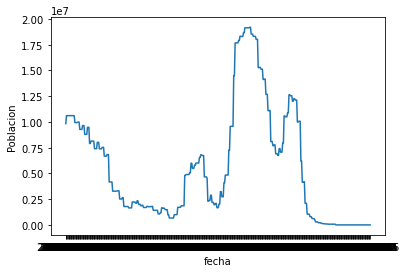

In [79]:
sns.lineplot(x='fecha', y='Poblacion', data=t)

In [80]:
t.loc[t['Poblacion'] == t.max()[0]] #asi, obtengo las fechas donde la numero de personas en cuarentena en todo el pais alcanzo su valor maximo, el que fue de 19191466 personas en las fechas 17 y 18 Abril del año 2021

,Poblacion
fecha,
2021-04-17,19191466
2021-04-18,19191466


In [81]:
paspobr1=paspobr[(paspobr['codigo_region']==1)]
paspobr2=paspobr[(paspobr['codigo_region']==2)]
paspobr3=paspobr[(paspobr['codigo_region']==3)]
paspobr4=paspobr[(paspobr['codigo_region']==4)]
paspobr5=paspobr[(paspobr['codigo_region']==5)]
paspobr6=paspobr[(paspobr['codigo_region']==6)]
paspobr7=paspobr[(paspobr['codigo_region']==7)]
paspobr8=paspobr[(paspobr['codigo_region']==8)]
paspobr9=paspobr[(paspobr['codigo_region']==9)]
paspobr10=paspobr[(paspobr['codigo_region']==10)]
paspobr11=paspobr[(paspobr['codigo_region']==11)]
paspobr12=paspobr[(paspobr['codigo_region']==12)]
paspobr13=paspobr[(paspobr['codigo_region']==13)]
paspobr14=paspobr[(paspobr['codigo_region']==14)]
paspobr15=paspobr[(paspobr['codigo_region']==15)]
paspobr16=paspobr[(paspobr['codigo_region']==16)]
#asumiendo que lo que hice estuvo bien, puedo crear distintas tablas que solo contengan una region en particular segun el codigo de region que posea, tomando la condicion de ir tomando "codigo_region" de 1 a 16

In [82]:
paspobr1.drop('codigo_region', axis=1, inplace=True)
paspobr2.drop('codigo_region', axis=1, inplace=True)
paspobr3.drop('codigo_region', axis=1, inplace=True)
paspobr4.drop('codigo_region', axis=1, inplace=True)
paspobr5.drop('codigo_region', axis=1, inplace=True)
paspobr6.drop('codigo_region', axis=1, inplace=True)
paspobr7.drop('codigo_region', axis=1, inplace=True)
paspobr8.drop('codigo_region', axis=1, inplace=True)
paspobr9.drop('codigo_region', axis=1, inplace=True)
paspobr10.drop('codigo_region', axis=1, inplace=True)
paspobr11.drop('codigo_region', axis=1, inplace=True)
paspobr12.drop('codigo_region', axis=1, inplace=True)
paspobr13.drop('codigo_region', axis=1, inplace=True)
paspobr14.drop('codigo_region', axis=1, inplace=True)
paspobr15.drop('codigo_region', axis=1, inplace=True)
paspobr16.drop('codigo_region', axis=1, inplace=True)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

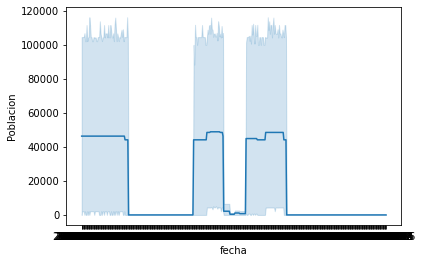

In [83]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr1) #realizo graficos de cada region, el x se ve como una linea negre porque son todos los dias dentro de los datos 

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

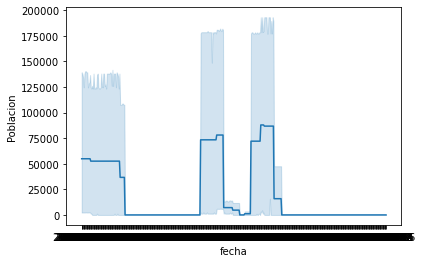

In [84]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr2)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

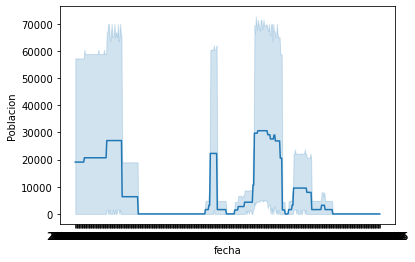

In [85]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr3)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

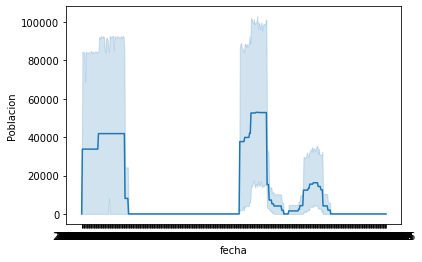

In [86]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr4)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

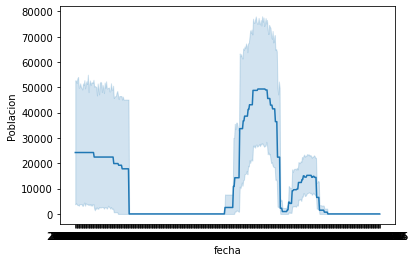

In [87]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr5)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

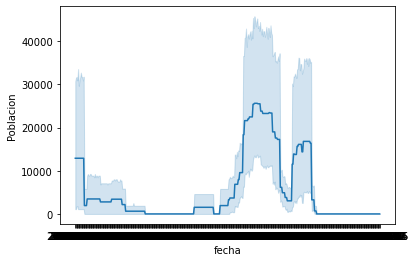

In [88]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr6)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

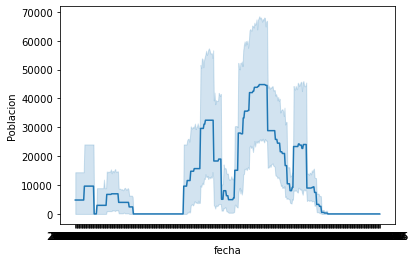

In [89]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr7)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

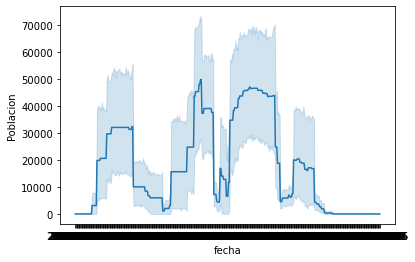

In [90]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr8)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

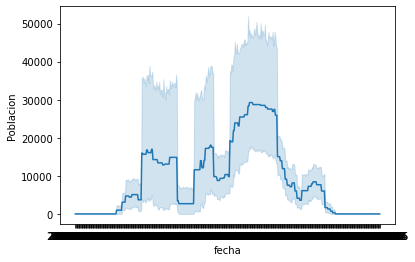

In [91]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr9)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

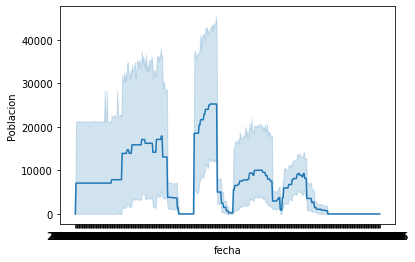

In [92]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr10)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

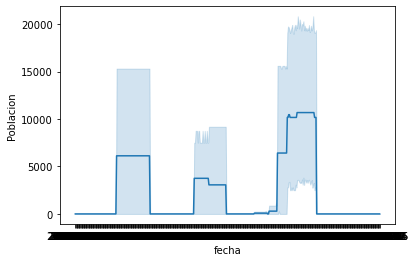

In [93]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr11)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

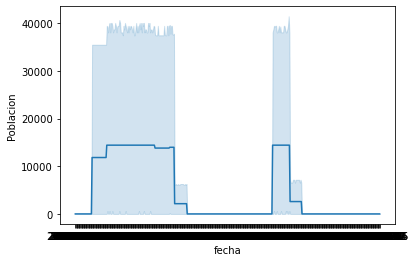

In [94]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr12)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

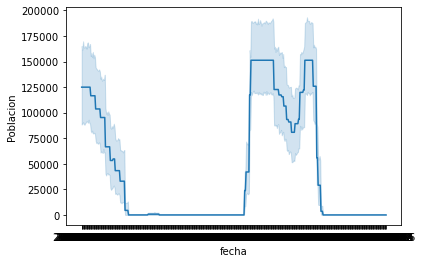

In [95]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr13)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

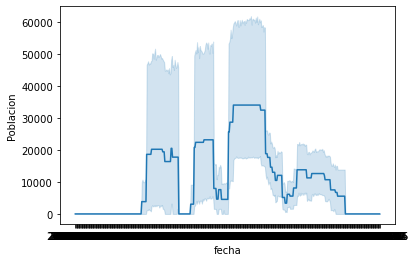

In [96]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr14)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

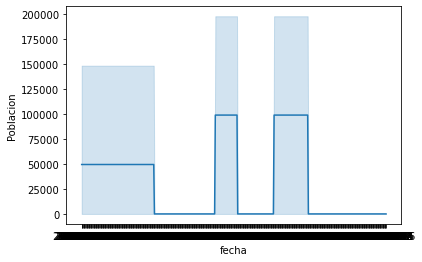

In [97]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr15)

<AxesSubplot:xlabel='fecha', ylabel='Poblacion'>

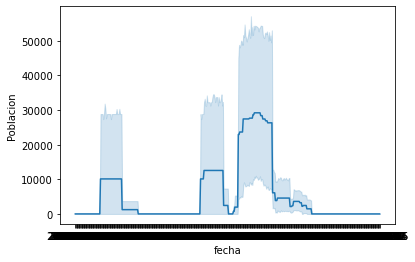

In [98]:
sns.lineplot(x='fecha', y='Poblacion', data=paspobr16)

In [99]:
paspobr16.groupby(['fecha']).sum() #por groupby, puedo ver en cada fecha el total de poblacion que se encontraba en cuarentena en la region, usare la letra s# para acortar codigo para adelante

,Poblacion
fecha,
2020-07-28,0
2020-07-29,0
2020-07-30,0
2020-07-31,0
2020-08-01,0
...,...
2021-10-02,0
2021-10-03,0
2021-10-04,0


In [100]:
s1=paspobr1.groupby(['fecha']).sum()
s2=paspobr2.groupby(['fecha']).sum()
s3=paspobr3.groupby(['fecha']).sum()
s4=paspobr4.groupby(['fecha']).sum()
s5=paspobr5.groupby(['fecha']).sum()
s6=paspobr6.groupby(['fecha']).sum()
s7=paspobr7.groupby(['fecha']).sum()
s8=paspobr8.groupby(['fecha']).sum()
s9=paspobr9.groupby(['fecha']).sum()
s10=paspobr10.groupby(['fecha']).sum()
s11=paspobr11.groupby(['fecha']).sum()
s12=paspobr12.groupby(['fecha']).sum()
s13=paspobr13.groupby(['fecha']).sum()
s14=paspobr14.groupby(['fecha']).sum()
s15=paspobr15.groupby(['fecha']).sum()
s16=paspobr16.groupby(['fecha']).sum()

In [101]:
s1

,Poblacion
fecha,
2020-07-28,370857
2020-07-29,370857
2020-07-30,370857
2020-07-31,370857
2020-08-01,370857
...,...
2021-10-02,0
2021-10-03,0
2021-10-04,0


In [102]:
s1.max()[0]

391252

In [103]:
s1.loc[s1['Poblacion'] == s1.max()[0]] #con esto obtengo todos los dias donde la region tuvo el maximo valor, repito lo mismo para cada region y obtendre las fechas donde la region alcanzo el maximo de personas en cuarentena

,Poblacion
fecha,
2021-01-28,391252
2021-01-29,391252
2021-01-30,391252
2021-01-31,391252
2021-02-01,391252
2021-02-02,391252
2021-02-03,391252
2021-02-04,391252
2021-02-05,391252


In [104]:
s2.loc[s2['Poblacion'] == s2.max()[0]]

,Poblacion
fecha,
2021-04-10,1055443
2021-04-11,1055443
2021-04-12,1055443
2021-04-13,1055443
2021-04-14,1055443


In [105]:
s3.loc[s3['Poblacion'] == s3.max()[0]]

,Poblacion
fecha,
2021-04-15,275723
2021-04-16,275723
2021-04-17,275723
2021-04-18,275723
2021-04-19,275723
2021-04-20,275723
2021-04-21,275723
2021-04-22,275723
2021-04-23,275723


In [106]:
s4.loc[s4['Poblacion'] == s4.max()[0]]

,Poblacion
fecha,
2021-04-03,793772
2021-04-04,793772
2021-04-05,793772
2021-04-06,793772
2021-04-07,793772


In [107]:
s5.loc[s5['Poblacion'] == s5.max()[0]]

,Poblacion
fecha,
2021-04-15,1875007
2021-04-16,1875007
2021-04-17,1875007
2021-04-18,1875007
2021-04-19,1875007
2021-04-20,1875007
2021-04-21,1875007
2021-04-22,1875007
2021-04-23,1875007


In [108]:
s6.loc[s6['Poblacion'] == s6.max()[0]]

,Poblacion
fecha,
2021-04-10,845196
2021-04-11,845196
2021-04-12,845196
2021-04-13,845196
2021-04-14,845196


In [109]:
s7.loc[s7['Poblacion'] == s7.max()[0]]

,Poblacion
fecha,
2021-04-17,1523404
2021-04-18,1523404
2021-04-19,1523404
2021-04-20,1523404
2021-04-21,1523404
2021-04-22,1523404
2021-04-23,1523404
2021-04-24,1523404
2021-04-25,1523404


In [110]:
s8.loc[s8['Poblacion'] == s8.max()[0]]

,Poblacion
fecha,
2021-01-23,1741315
2021-01-24,1741315


In [111]:
s9.loc[s9['Poblacion'] == s9.max()[0]]

,Poblacion
fecha,
2021-04-03,1053231
2021-04-04,1053231
2021-04-05,1053231
2021-04-06,1053231
2021-04-07,1053231


In [112]:
s10.loc[s10['Poblacion'] == s10.max()[0]]

,Poblacion
fecha,
2021-02-06,960744
2021-02-07,960744
2021-02-08,960744
2021-02-09,960744
2021-02-10,960744
2021-02-11,960744
2021-02-12,960744
2021-02-13,960744
2021-02-14,960744


In [113]:
s11.loc[s11['Poblacion'] == s11.max()[0]]

,Poblacion
fecha,
2021-06-10,213496
2021-06-11,213496
2021-06-12,213496
2021-06-13,213496
2021-06-14,213496
2021-06-15,213496
2021-06-16,213496
2021-06-17,213496
2021-06-18,213496


In [114]:
s12.loc[s12['Poblacion'] == s12.max()[0]]

,Poblacion
fecha,
2020-09-11,173089
2020-09-12,173089
2020-09-13,173089
2020-09-14,173089
2020-09-15,173089
...,...
2021-05-26,173089
2021-05-27,173089
2021-05-28,173089


In [115]:
s13.loc[s13['Poblacion'] == s13.max()[0]]

,Poblacion
fecha,
2021-03-27,8321758
2021-03-28,8321758
2021-03-29,8321758
2021-03-30,8321758
2021-03-31,8321758
2021-04-01,8321758
2021-04-02,8321758
2021-04-03,8321758
2021-04-04,8321758


In [116]:
s14.loc[s14['Poblacion'] == s14.max()[0]]

,Poblacion
fecha,
2021-03-11,441826
2021-03-12,441826
2021-03-13,441826
2021-03-14,441826
2021-03-15,441826
2021-03-16,441826
2021-03-17,441826
2021-03-18,441826
2021-03-19,441826


In [117]:
s15.loc[s15['Poblacion'] == s15.max()[0]]

,Poblacion
fecha,
2021-02-04,495104
2021-02-05,495104
2021-02-06,495104
2021-02-07,495104
2021-02-08,495104
...,...
2021-06-12,495104
2021-06-13,495104
2021-06-14,495104


In [118]:
s16.loc[s16['Poblacion'] == s16.max()[0]]

,Poblacion
fecha,
2021-04-10,671615
2021-04-11,671615
2021-04-12,671615
2021-04-13,671615
2021-04-14,671615
2021-04-15,671615
2021-04-16,671615
2021-04-17,671615
2021-04-18,671615
